In [8]:
import numpy as np
import pandas as pd
from mesa import batch_run
import matplotlib.pyplot as plt
from model import SugarscapeG1mt

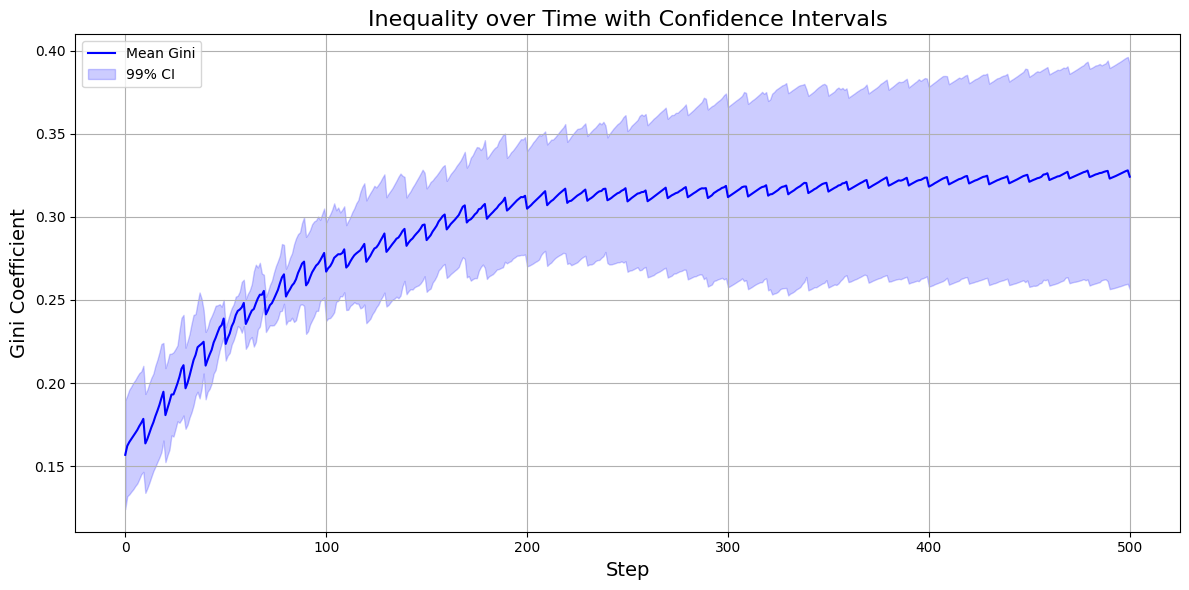

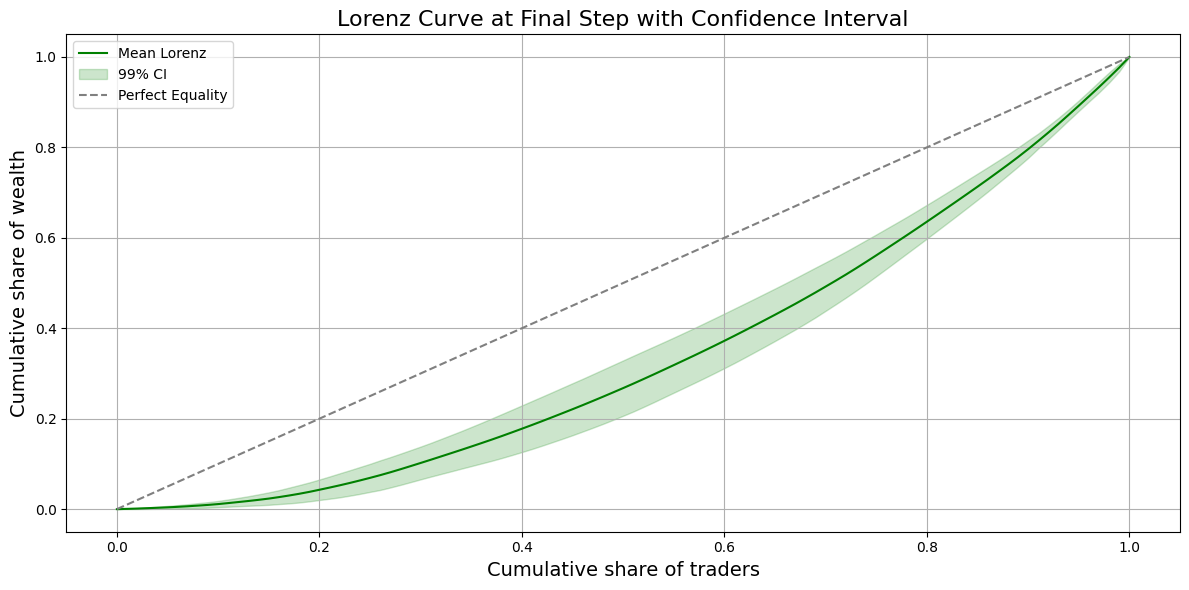

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from tqdm import trange

# --- Model Setup --- #
NUM_RUNS = 5
NUM_STEPS = 500
confidence = 0.99
model_args = dict(
    initial_population=100, 
    endowment_min=20,
    endowment_max=100,
    metabolism_min=1,
    metabolism_max=3,
    vision_min=1,
    vision_max=5,
    wealth_tax_system="none",
    flat_rate=0.03,
    wealth_tax_period=10,
    income_tax_system="progressive",
    income_tax_flat_rate=0.3,
    income_tax_brackets=None,
    vat_rate_sugar = .0,
    vat_rate_spice = .0 , 
    redistribution_regime = "social",
    enable_trade=True,
    seed=None,
    enable_staghunt=False,
)

# --- Experiments --- #
gini_runs = []
lorenz_runs = []

for run in range(NUM_RUNS):
    model = SugarscapeG1mt(**model_args)
    for _ in range(NUM_STEPS):
        model.step()
    df = model.datacollector.get_model_vars_dataframe()
    gini_runs.append(df["Gini"].values)
    lorenz_runs.append(df["Lorenz"].iloc[-1])  # final step only

gini_array = np.array(gini_runs)  # shape: (runs, steps)

# --- Gini Part --- #
mean_gini = gini_array.mean(axis=0)
sem_gini = gini_array.std(axis=0, ddof=1) / np.sqrt(NUM_RUNS)
ci_range = t.ppf((1 + confidence) / 2., NUM_RUNS - 1) * sem_gini
lower_ci = mean_gini - ci_range
upper_ci = mean_gini + ci_range

plt.figure(figsize=(12,6))
plt.plot(mean_gini, label="Mean Gini", color='blue')
plt.fill_between(range(NUM_STEPS + 1), lower_ci, upper_ci, color='blue', alpha=0.2, label=f"{int(confidence*100)}% CI")
plt.xlabel("Step", fontsize=14)
plt.ylabel("Gini Coefficient", fontsize=14)
plt.title("Inequality over Time with Confidence Intervals", fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Lorenz part --- #
# We assume x-values = population are the same for all runs, and only y varies
x_vals = np.array([x for x, _ in lorenz_runs[0]])
y_arrays = np.array([[y for _, y in lorenz] for lorenz in lorenz_runs])  # shape: (runs, points)

mean_y = y_arrays.mean(axis=0)
sem_y = y_arrays.std(axis=0, ddof=1) / np.sqrt(NUM_RUNS)
ci_range_y = t.ppf((1 + confidence) / 2., NUM_RUNS - 1) * sem_y
lower_y = mean_y - ci_range_y
upper_y = mean_y + ci_range_y

plt.figure(figsize=(12,6))
plt.plot(x_vals, mean_y, label="Mean Lorenz", color='green')
plt.fill_between(x_vals, lower_y, upper_y, color='green', alpha=0.2, label=f"{int(confidence*100)}% CI")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Equality")
plt.xlabel("Cumulative share of traders", fontsize=14)
plt.ylabel("Cumulative share of wealth", fontsize=14)
plt.title("Lorenz Curve at Final Step with Confidence Interval", fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# OLD CODE

In [ ]:
from pathlib import Path

# 1. Read the original grid from file
with open("sugar_distribution_output.txt", "r", encoding="utf-8") as f:
    grid_raw = f.read()

# 2. Parse into list-of-lists of ints
rows = [[int(x) for x in line.split()] for line in grid_raw.strip().splitlines()]
if len(rows) != 50 or any(len(r) != 50 for r in rows):
    raise ValueError(f"Expected a 50×50 grid, got {[len(rows)]}×{[len(rows[0])]}")

# 3. Zero everything except top-right 25×25 quadrant
for i in range(50):
    for j in range(50):
        if not (i < 25 and j >= 25):  # outside top-right
            rows[i][j] = 0
        else:
            rows[i][j] = rows[i][j] * 2

# 4. Convert to string and write to new file
new_grid_str = "\n".join(" ".join(str(x) for x in row) for row in rows) + "\n"
Path("sugar_map2.txt").write_text(new_grid_str, encoding="utf-8")

print("✔️  Wrote sugar_map2.txt with top-right quadrant preserved.")


✔️  Wrote sugar_map2.txt with top-right quadrant preserved.
